# 1.Import Data

In [1]:
import numpy as np
import pickle
import sklearn
import tensorflow as tf
from tqdm import tqdm

In [2]:
# function for loading pickle file
def loadPickle(file_name):
    picklefile = open('.\\DataSet\\'+file_name+".pkl",mode="rb")
    data = pickle.load(picklefile)
    picklefile.close()
    return data

In [3]:
y_train = loadPickle('y_train')
y_test = loadPickle('y_test')
X_train = loadPickle('X_train_vec')
X_test = loadPickle('X_test_vec')

# 2. Preprocessing for padding the matrix to same size
## 2.1. Get Max Length of Rows in X

In [4]:
# increase the length of each text in each row till it matches the max length of all the texts
def getlenMax(input_data):
    'function for estimating the max length of text in data'
    max_no = 0
    for text in input_data:
        num_word = len(text)
        if max_no <= num_word:
            max_no = num_word

    return max_no

def compare(train,test):
    'function for comparison between test and train'
    no_train = getlenMax(train)
    no_test = getlenMax(test)
    if no_train > no_test:
        return no_train
    else:
        return no_test

In [5]:
max_len = compare(X_train,X_test)
print(max_len) # get the max length of rows in X

4327


## 2.2. Padding the format
#### because LSTM is time-series model, pre-padding make more sense

In [6]:
def extendText(input_data, len_max,padding="pre",dimension=300):
    content=list()
    if padding == "post":
        for text in tqdm(input_data):
            add_no = len_max - len(text)
            x = np.zeros((add_no,dimension))
            new_text = np.vstack((text,x))#padding is post
            content.append(new_text)
            
    elif padding == "pre":
        for text in tqdm(input_data):
            add_no = len_max - len(text)
            x = np.zeros((add_no,dimension))
            new_text = np.vstack((x,text))#padding is pre
            content.append(new_text)

    content = np.array(content)
    return content

In [7]:
test = [[[1,2,3],[3,4,5]],[[1,2,3],[4,5,6]]]
test = np.array(test)
test = extendText(test,max_len,padding = 'post',dimension=3)
print(test)
print(len(test[0]))

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2005.88it/s]

[[[1. 2. 3.]
  [3. 4. 5.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 2. 3.]
  [4. 5. 6.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
4327


In [8]:
X_train = extendText(X_train,max_len,padding = 'post')
X_test = extendText(X_test,max_len,padding = 'post')

100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [00:15<00:00, 22.41it/s]


# 3. Build 1dCNN
## 3.1. Initialize the Model and Add the Layers

In [17]:
# import libraries
import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [18]:
# firstly we need to make sure our input share the same format
input_shape = X_train[0].shape
print(input_shape) # this means 300 length vectors with 162 timesteps

(4327, 300)


In [21]:
def modelBuild(input_shape):
    # initialize CNN model
    model = tf.keras.Sequential()
    
    # add 1st convolution layer. here particularly need input_shape
    model.add(Conv1D(filters=150, kernel_size=2, activation="relu",padding="same", input_shape=input_shape))
    
    # add 2nd convolution layer with different kernal_size 3
    model.add(Conv1D(filters=150, kernel_size=3, activation="relu",padding="same"))
    
    # add 3rd convolution layer with different kernal_size 4
    model.add(Conv1D(filters=150, kernel_size=4, activation="relu",padding="same"))
    # add 1st max pooling, because sentences share different length, so I only count max value from each feature map.
    # therefore ,finally when I get to the ann input layer, I can have fixed dimensionality of input data.
    model.add(MaxPooling1D(pool_size=max_len,padding="valid"))
    model.add(Dropout(0.2))
    
    # add flattern
    model.add(Flatten())
    
    # from now on it's ANN analysis layer, we set enough neurons for full connection, add 1st hidden layer
    # because sentences are built based on fluent thinking style, so I use rectifier as activation function to avoid gradual change
    model.add(Dense(units=5, activation='relu'))
    
    # here I add 2nd hidden layer
    model.add(Dense(units=5, activation='relu'))
    
    # add output layer, since the category of label is "happy, sad, angry, others", i use 4 neurons as output outcome
    # it's because I also need the possibility for the prediction, so I set sigmoid as activation function
    model.add(Dense(units=1, activation='sigmoid'))
    
    return model

## 3.2. Compilation

In [22]:
model = modelBuild(input_shape)

In [23]:
# compilation
# we use stochastic gradient descent as our optimizer, cross entropy as our loss function
# it's because I use integer binary result [0,1] as label, so I use binary crossentropy as my loss function
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4327, 150)         90150     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4327, 150)         67650     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4327, 150)         90150     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 150)            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 150)            0         
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                

## 3.3. Function for Storage of Model

In [25]:
# global parameter
modelname="1dCNN"

In [26]:
def saveModel(model,modelname):
    model_json=model.to_json()
    # specialize model to json
    name_path = "DataSet\\{a}".format(a=modelname)
    with open(name_path+".json","w") as json_file:
        json_file.write(model_json)
        
    # sepcialize weights to HDF5
    model.save_weights(name_path+".h5")
    print("Save model to DataSet archive successfully")

# 4. Train Model

In [27]:
epochs = 2
batch = 50
vali_split=0.1
# though validation_data is not used in propagation, the model will be gradually familier with validation data. There can be information leak.
# therefore, normally use validation_split for testing model to avoid overfitting

In [28]:
history = model.fit(x = X_train,y=y_train,validation_split=vali_split, epochs =epochs, batch_size=batch)
saveModel(model,modelname)

Epoch 1/2
26/26 [==============================] - 32s 1s/step - loss: 0.5361 - accuracy: 0.7363 - val_loss: 0.3488 - val_accuracy: 1.0000
Epoch 2/2
26/26 [==============================] - 31s 1s/step - loss: 0.3455 - accuracy: 0.9897 - val_loss: 0.3368 - val_accuracy: 1.0000
Save model to DataSet archive successfully


# 5. Load Model

In [29]:
def loadModel(modelname):
    # load json file
    load_path = ".\\DataSet\\{a}".format(a=modelname)
    json_file = open(load_path+".json",'r')
    model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(model_json)
    # load weights and assign them to the model
    model.load_weights(load_path+".h5")
    print("loaded {a} model successfully".format(a=modelname))
    
    return model

In [30]:
model = loadModel(modelname)

loaded 1dCNN model successfully


# 6. Prediction

In [31]:
y_possible = model.predict(X_test)

In [32]:
y_possible

array([[1.1287034e-03],
       [4.8477650e-03],
       [5.1307034e-01],
       [2.6535988e-04],
       [5.3137541e-04],
       [5.1307034e-01],
       [5.1307034e-01],
       [1.8053949e-03],
       [5.1307034e-01],
       [1.2528598e-03],
       [3.1706691e-04],
       [6.9814920e-04],
       [1.0477304e-03],
       [5.1307034e-01],
       [2.6357174e-04],
       [5.1307034e-01],
       [5.1307034e-01],
       [5.1307034e-01],
       [3.5810471e-04],
       [5.1307034e-01],
       [5.1307034e-01],
       [3.5080314e-04],
       [5.1307034e-01],
       [2.0778179e-04],
       [5.1307034e-01],
       [1.7642975e-04],
       [5.1307034e-01],
       [5.1307034e-01],
       [1.4255047e-03],
       [5.1307034e-01],
       [7.6261103e-02],
       [1.2271404e-03],
       [3.7661195e-04],
       [5.1307034e-01],
       [4.7707558e-04],
       [4.9573183e-04],
       [7.8243017e-04],
       [5.1307034e-01],
       [1.4064908e-03],
       [5.1307034e-01],
       [5.1307034e-01],
       [4.319548

In [33]:
def setResult(y_possible,standard):
    y_preds = list()
    for each in y_possible:
        if each >= standard:
            y_preds.append(1)
        else:
            y_preds.append(0)
    y_preds=np.array(y_preds)
    return y_preds

In [34]:
y_preds=setResult(y_possible,standard=0.5)

In [35]:
y_preds

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,

# 7.Evaluation
## 7.1. Learning Curve

In [36]:
import matplotlib.pyplot as plt

def plot_learningCurve(history,epochs,modelname):
    epoch_range = range(1, epochs +1)
    plt.figure()
    plt.plot(epoch_range,history.history['accuracy'],color='b',label='accuracy')
    plt.plot(epoch_range,history.history['val_accuracy'],color='r',label='validation accuracy')
    plt.xlim([0.0,epochs+1.0])
    plt.ylim([0.0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('History of {a} Model Accuracy'.format(a=modelname))
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\History of {a} Model Accuracy.png".format(a=modelname))
    plt.show()
    
    plt.figure()
    plt.plot(epoch_range,history.history['loss'],color='b',label='loss')
    plt.plot(epoch_range,history.history['val_loss'],color='r',label='validation loss')
    plt.xlim([0.0,epochs+1.0])
    plt.ylim([0.0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('History of {a} Model Loss'.format(a=modelname))
    plt.legend(loc="upper left")
    plt.savefig("Pictures\\History of {a} Model Loss.png".format(a=modelname))
    plt.show()

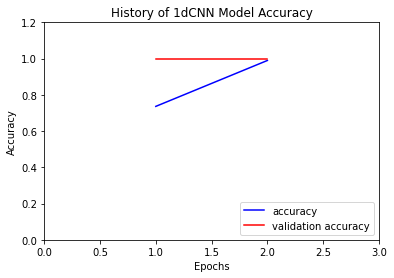

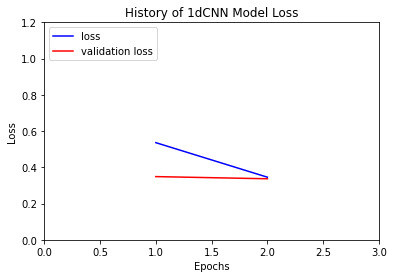

In [37]:
plot_learningCurve(history,epochs,modelname)

## 7.2. F1 Score and Other Measures 

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def getEvaluation(y_test,y_pred,X_test, model):
    ev = dict()
    ev["confusion_matrix"]=confusion_matrix(y_test,y_pred)
    ev["accuracy"] = accuracy_score(y_test,y_pred)
    ev["precision"]=precision_score(y_test,y_pred,average="binary")
    ev["recall"]=recall_score(y_test,y_pred,average="binary")
    ev["F1 score"]=f1_score(y_test,y_pred,average="binary")
    
    for key in ev.keys():
        if key !="confusion_matrix":
            print("{a} is: {b}".format(a=key, b=ev[key]))
        else:
            print(ev[key])
    
    # and also the basic evaluation from keras
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    eval_ = model.evaluate(X_test,y_test)
    print("Loss: {0:.7}".format(eval_[0]))
    print("Accuracy: {0:.2%}".format(eval_[1]))
    
    return ev

In [39]:
ev = getEvaluation(y_test,y_preds,X_test,model)

[[185   0]
 [  3 163]]
accuracy is: 0.9914529914529915
precision is: 1.0
recall is: 0.9819277108433735
F1 score is: 0.9908814589665653
11/11 [==============================] - 2s 217ms/step - loss: 0.3247 - accuracy: 0.9915
Loss: 0.3246878
Accuracy: 99.15%
